In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_df = pd.read_csv('drive/MyDrive/datasets/input_data_after_preprocessing_for_ml.csv')
#my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,Unnamed: 0,Combined Description Cleaned,Assignment group
0,0,login issue user manager name checked the name...,GRP_0
1,1,outlook received from hello team my are not in...,GRP_0
2,2,cannot log in to received from hi i cannot on ...,GRP_0
3,3,unable to access tool page,GRP_0
4,4,error,GRP_0


In [4]:
df2 = my_df
my_df['Assignment group by number'] = my_df['Assignment group'].str[4:]
my_df['Assignment group by number'] = my_df['Assignment group by number'].astype(int)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    8500 non-null   int64 
 1   Combined Description Cleaned  8500 non-null   object
 2   Assignment group              8500 non-null   object
 3   Assignment group by number    8500 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 265.8+ KB


In [5]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    8500 non-null   int64 
 1   Combined Description Cleaned  8500 non-null   object
 2   Assignment group              8500 non-null   object
 3   Assignment group by number    8500 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 265.8+ KB


In [6]:
x = my_df['Combined Description Cleaned']
y = my_df['Assignment group by number']

In [7]:
#y = tf.keras.utils.to_categorical(y)

In [8]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02,
                                                                                  random_state=SEED, shuffle=True)
                                                                                 # stratify=y)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [9]:
y_train.shape

(8330,)

In [10]:
y_validation.shape

(85,)

In [11]:
from sklearn.linear_model import LogisticRegression

## Doc2Vec

Before we jump into doc2vec, it will be better to first start by word2vec. "Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words."

DM: 
This is the Doc2Vec model analogous to CBOW model in Word2vec. The paragraph vectors are obtained by training a neural network on the task of inferring a centre word based on context words and a context paragraph. 

DBOW:
This is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Below are the methods I used to get the vectors for each ticket.

1. DBOW (Distributed Bag of Words)
2. DMC (Distributed Memory Concatenated)
3. DMM (Distributed Memory Mean)
4. DBOW + DMC
5. DBOW + DMM

With above vectors, I fit a simple logistic regression model and evaluated the result on the validation set.

In [12]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [13]:
def labelize_tickets_ug(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

Also, the same rationale has been applied in the Gensim's Doc2Vec tutorial. In the IMDB tutorial, vector training is occurring on all documents of the data set, including all train/test/dev set. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [14]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tickets_ug(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [15]:
len(all_x_w2v)

8500

In [16]:
all_x_w2v

[LabeledSentence(words=['we', 'need', 'a', 'for', 'material', 'plant', 'plant', 'thanks'], tags=['all_4587']),
 LabeledSentence(words=['account', 'locked', 'out'], tags=['all_1728']),
 LabeledSentence(words=['account', 'locked', 'in', 'ad'], tags=['all_6771']),
 LabeledSentence(words=['with', 'ie'], tags=['all_5292']),
 LabeledSentence(words=['jpg', 'files', 'encrypted'], tags=['all_698']),
 LabeledSentence(words=['action', 'could', 'not', 'be', 'is', 'getting', 'the', 'following', 'error', 'message', 'when', 'trying', 'to', 'access', 'no', 'data', 'found', 'for', 'employee', 'inform', 'system', 'administration', 'please', 'sync', 'her'], tags=['all_1189']),
 LabeledSentence(words=['account', 'lockout'], tags=['all_6729']),
 LabeledSentence(words=['invalid', 'incompletion', 'error', 'on', 'so', 'so', 'configuration', 'for', 'which', 'is', 'invalid', 'these', 'are', 'complete', 'and', 'should', 'not', 'be', 'there'], tags=['all_4620']),
 LabeledSentence(words=['account', 'locked'], tags

## DBOW

In [17]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 1830257.41it/s]


According to the developer Radim Řehůřek who created Gensim,
"One caveat of the way this algorithm runs is that, since the learning rate decrease over the course of iterating over the data, labels which are only seen in a single LabeledSentence during training will only be trained with a fixed learning rate. This frequently produces less than optimal results."

Below iteration implement explicit multiple-pass, alpha-reduction approach with added shuffling. This has been already presented in Gensim's IMDB tutorial.

In [18]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3505219.15it/s]


CPU times: user 17.8 s, sys: 3.41 s, total: 21.2 s
Wall time: 14 s


In [19]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [20]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

In [21]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')

clf.fit(train_vecs_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
clf.score(validation_vecs_dbow, y_validation)

0.6

Even though the DBOW model doesn't learn the meaning of the individual words, but as features to feed to a classifier, it seems like it's doing its job.

But the result doesn't seem to excel count vectorizer or Tfidf vectorizer. It might not be a direct comparison since either count vectorizer of Tfidf vectorizer uses a large number of features to represent a tweet, but in this case, a vector for each tweet has only 200 dimensions.

In [23]:
model_ug_dbow.save('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')

In [24]:
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (concatenated)

In [25]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2282577.89it/s]


In [26]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3015443.12it/s]


CPU times: user 23.7 s, sys: 4.44 s, total: 28.2 s
Wall time: 15.8 s


In [27]:
#model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')


What's nice about Doc2Vec is that after training you can retrieve not only document vectors but also individual word vectors as well. Note, however, that a Doc2Vec DBOW model doesn't learn semantic word vectors, so the word vectors you retrieve from pure DBOW model will be the automatic randomly-initialized vectors, with no meaning.
But with DM model, you can see the semantic relationship between words. Let's see what word vectors it has learned through training.

In [28]:
model_ug_dmc.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dear', 0.5148715972900391),
 ('attention', 0.5049057006835938),
 ('gen', 0.44643864035606384),
 ('every', 0.4239773154258728),
 ('helper', 0.4186507761478424),
 ('termination', 0.41811826825141907),
 ('nice', 0.41403940320014954),
 ('rough', 0.4115770757198334),
 ('analyst', 0.4098779261112213),
 ('hello', 0.40950220823287964)]

In [29]:
model_ug_dmc.most_similar('network')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('inside', 0.44480520486831665),
 ('passive', 0.43222352862358093),
 ('paternoster', 0.41477370262145996),
 ('indexing', 0.4102599620819092),
 ('dialing', 0.39734983444213867),
 ('car', 0.39240318536758423),
 ('defect', 0.3900008499622345),
 ('ontology', 0.38360410928726196),
 ('industrial', 0.3833369016647339),
 ('variable', 0.3831190764904022)]

What's interesting with DMC model is, somehow it learned all the misspelled version of a word as you can see from the above.

In [30]:
model_ug_dmc.most_similar('password')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('reset', 0.49905556440353394),
 ('bin', 0.4827459454536438),
 ('random', 0.4753093123435974),
 ('solely', 0.46808236837387085),
 ('evil', 0.4546862244606018),
 ('fae', 0.4541621506214142),
 ('\\', 0.43483591079711914),
 ('auditor', 0.420340359210968),
 ('mason', 0.4202093482017517),
 ('decent', 0.41862374544143677)]

In [31]:
model_ug_dmc.most_similar(positive=['bigger', 'small'], negative=['big'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('question', 0.4342536926269531),
 ('mismatch', 0.41386842727661133),
 ('impacted', 0.39028024673461914),
 ('bitter', 0.3862360715866089),
 ('arc', 0.37878936529159546),
 ('hot', 0.37869352102279663),
 ('preserve', 0.3741993308067322),
 ('coffee', 0.35841649770736694),
 ('rerun', 0.35810136795043945),
 ('often', 0.3574002981185913)]

The model successfully catches the comparative form of "small", on feeding the word "big" and "bigger". The above line of code is like asking the model to add the vectors associated with the word "bigger" and "small" while subtracting "big" is equal to the top result, "smaller".

In [32]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

In [33]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dmc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
clf.score(validation_vecs_dmc, y_validation)

0.4588235294117647

In [35]:
model_ug_dmc.save('drive/MyDrive/grams/d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dmc.doc2vec')
model_ug_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (mean)

In [36]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 1968721.85it/s]


In [37]:
%%time
for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

100%|██████████| 8500/8500 [00:00<00:00, 2740532.25it/s]


CPU times: user 36.3 s, sys: 11.6 s, total: 47.9 s
Wall time: 31.1 s


In [38]:
model_ug_dmm.most_similar('schedule')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('job', 0.5794833898544312),
 ('arc', 0.5400528311729431),
 ('cold', 0.5025402903556824),
 ('notch', 0.42934975028038025),
 ('cluster', 0.4290768504142761),
 ('disclosure', 0.4102555215358734),
 ('middle', 0.38398557901382446),
 ('little', 0.36362823843955994),
 ('alert', 0.3617080748081207),
 ('partially', 0.3612569570541382)]

In [39]:
model_ug_dmc.most_similar('network')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('inside', 0.44480520486831665),
 ('passive', 0.43222352862358093),
 ('paternoster', 0.41477370262145996),
 ('indexing', 0.4102599620819092),
 ('dialing', 0.39734983444213867),
 ('car', 0.39240318536758423),
 ('defect', 0.3900008499622345),
 ('ontology', 0.38360410928726196),
 ('industrial', 0.3833369016647339),
 ('variable', 0.3831190764904022)]

In [40]:
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

In [41]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dmm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
clf.score(validation_vecs_dmm, y_validation)

0.5058823529411764

In [43]:
model_ug_dmm.save('drive/MyDrive/grams/d2v_model_ug_dmm.doc2vec')
model_ug_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

Since I have the document vectors from four different models, now I can concatenate them in combination to see how it affects the performance. Below I defined a simple function to concatenate document vectors from different models.

In [44]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [45]:
train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_train, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_validation, 200)

In [46]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_dmc, y_train)

CPU times: user 29.9 s, sys: 1min 13s, total: 1min 43s
Wall time: 26 s


In [47]:
clf.score(validation_vecs_dbow_dmc, y_validation)

0.5764705882352941

In [48]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_validation, 200)

In [49]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_dmm, y_train)

CPU times: user 49.4 s, sys: 1min 59s, total: 2min 48s
Wall time: 42.5 s


In [50]:
clf.score(validation_vecs_dbow_dmm, y_validation)

0.6235294117647059

In case of unigram, concatenating document vectors in different combination boosted the model performance. The best validation accuracy I got from a single model is from DBOW at 73.89%. With concatenated vectors, I get the highest validation accuracy of 75.51% with DBOW+DMM model.

In [51]:
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

In [52]:
tokenized_train = [t.split() for t in x_train]

In [53]:
%%time
phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

CPU times: user 634 ms, sys: 36.8 ms, total: 671 ms
Wall time: 617 ms


In [54]:
sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
print(bigram[sent])

['the', 'mayor', 'of', 'new', 'york', 'was', 'there']


In [55]:
x_train

4587            we need a for material plant plant thanks
1728                                   account locked out
6771                                 account locked in ad
5292                                              with ie
698                                   jpg files encrypted
                              ...                        
3762            performance for machine summary load list
4380                     external not with dell in tablet
1590                please give access to all under mu is
4045    received from hi below apprentice is unable to...
4936                             user this message recall
Name: Combined Description Cleaned, Length: 8330, dtype: object

In [56]:
x_train[10]

'engineering tool not connected and unable to submit'

In [57]:
bigram[x_train[10].split()]

['engineering_tool', 'not', 'connected', 'and', 'unable_to', 'submit']

In [58]:
def labelize_tickets_bg(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(bigram[t.split()], [prefix + '_%s' % i]))
    return result

In [59]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_bg = labelize_tickets_bg(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


## DBOW Bigram

In [60]:
cores = multiprocessing.cpu_count()
model_bg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dbow.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 1683504.93it/s]


In [61]:
%%time
for epoch in range(30):
    model_bg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dbow.alpha -= 0.002
    model_bg_dbow.min_alpha = model_bg_dbow.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3348824.35it/s]


CPU times: user 16.5 s, sys: 4.55 s, total: 21.1 s
Wall time: 14.1 s


In [62]:
train_vecs_dbow_bg = get_vectors(model_bg_dbow, x_train, 100)
validation_vecs_dbow_bg = get_vectors(model_bg_dbow, x_validation, 100)

In [63]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_bg, y_train)

CPU times: user 22.1 s, sys: 30.4 s, total: 52.5 s
Wall time: 13.3 s


In [64]:
clf.score(validation_vecs_dbow_bg, y_validation)

0.5647058823529412

In [65]:
model_bg_dbow.save('drive/MyDrive/grams/d2v_model_bg_dbow.doc2vec')
model_bg_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dbow.doc2vec')
model_bg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

### DMC Bigram

In [66]:
cores = multiprocessing.cpu_count()
model_bg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmc.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2532792.27it/s]


In [67]:
%%time
for epoch in range(30):
    model_bg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmc.alpha -= 0.002
    model_bg_dmc.min_alpha = model_bg_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3245183.32it/s]


CPU times: user 22.3 s, sys: 4.61 s, total: 26.9 s
Wall time: 15.3 s


In [68]:
model_bg_dmc.most_similar('schedule')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cold', 0.5654117465019226),
 ('job_schedule', 0.5536006093025208),
 ('job', 0.5521701574325562),
 ('bend', 0.5483443737030029),
 ('your_organization', 0.547114372253418),
 ('hand_way', 0.5464956760406494),
 ('flight', 0.5332556962966919),
 ('assembly', 0.5328861474990845),
 ('status_bar', 0.5242373943328857),
 ('corresponding_back', 0.5221649408340454)]

In [69]:
train_vecs_dmc_bg = get_vectors(model_bg_dmc, x_train, 100)
validation_vecs_dmc_bg = get_vectors(model_bg_dmc, x_validation, 100)

In [70]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dmc_bg, y_train)

CPU times: user 9 s, sys: 12.7 s, total: 21.7 s
Wall time: 5.49 s


In [71]:
clf.score(validation_vecs_dmc_bg, y_validation)

0.4588235294117647

In [72]:
model_bg_dmc.save('drive/MyDrive/grams/d2v_model_bg_dmc.doc2vec')
model_bg_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dmc.doc2vec')
model_bg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM Bigram

In [73]:
cores = multiprocessing.cpu_count()
model_bg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmm.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2468604.35it/s]


In [74]:
%%time
for epoch in range(30):
    model_bg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmm.alpha -= 0.002
    model_bg_dmm.min_alpha = model_bg_dmm.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3434972.93it/s]


CPU times: user 34.8 s, sys: 14.1 s, total: 48.9 s
Wall time: 31.9 s


In [75]:
train_vecs_dmm_bg = get_vectors(model_bg_dmm, x_train, 100)
validation_vecs_dmm_bg = get_vectors(model_bg_dmm, x_validation, 100)

In [76]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dmm_bg, y_train)

CPU times: user 23.6 s, sys: 34.4 s, total: 58 s
Wall time: 14.6 s


In [77]:
clf.score(validation_vecs_dmm_bg, y_validation)

0.5058823529411764

In [78]:
model_bg_dmm.save('drive/MyDrive/grams/d2v_model_bg_dmm.doc2vec')
model_bg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dmm.doc2vec')
model_bg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [79]:
train_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_train, 200)
validation_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_validation, 200)

In [80]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_dmc_bg, y_train)

CPU times: user 30.2 s, sys: 1min 10s, total: 1min 40s
Wall time: 25.4 s


In [81]:
clf.score(validation_vecs_dbow_dmc_bg, y_validation)

0.6

In [82]:
train_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_train, 200)
validation_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_validation, 200)

In [83]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_dmm_bg, y_train)

CPU times: user 43.6 s, sys: 1min 32s, total: 2min 16s
Wall time: 34.4 s


In [84]:
clf.score(validation_vecs_dbow_dmm_bg, y_validation)

0.6

## Trigram

In [85]:
%%time
tg_phrases = Phrases(bigram[tokenized_train])
trigram = Phraser(tg_phrases)

CPU times: user 1.09 s, sys: 343 ms, total: 1.44 s
Wall time: 1.08 s


In [86]:
trigram[bigram[x_train[10].split()]]

['engineering_tool', 'not', 'connected', 'and', 'unable_to_submit']

## Below Doc2Vec implementation is again same as unigram or bigram.

In [87]:
def labelize_tickets_tg(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(trigram[bigram[t.split()]], [prefix + '_%s' % i]))
    return result

In [88]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_tg = labelize_tickets_tg(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


## DBOW Trigram

In [89]:
model_tg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dbow.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2365104.42it/s]


In [90]:
%%time
for epoch in range(30):
    model_tg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dbow.alpha -= 0.002
    model_tg_dbow.min_alpha = model_tg_dbow.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3200321.72it/s]


CPU times: user 16.9 s, sys: 4.81 s, total: 21.7 s
Wall time: 14.2 s


In [91]:
train_vecs_dbow_tg = get_vectors(model_tg_dbow, x_train, 100)
validation_vecs_dbow_tg = get_vectors(model_tg_dbow, x_validation, 100)

In [92]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_tg, y_train)

CPU times: user 21.2 s, sys: 29.6 s, total: 50.8 s
Wall time: 12.8 s


In [93]:
clf.score(validation_vecs_dbow_tg, y_validation)

0.5764705882352941

In [94]:
model_tg_dbow.save('drive/MyDrive/grams/d2v_model_tg_dbow.doc2vec')
model_tg_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dbow.doc2vec')
model_tg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMC Trig

In [95]:
cores = multiprocessing.cpu_count()
model_tg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmc.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2305009.63it/s]


In [96]:
%%time
for epoch in range(30):
    model_tg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmc.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 2854867.39it/s]


CPU times: user 21.1 s, sys: 4.45 s, total: 25.6 s
Wall time: 14.7 s


In [97]:
train_vecs_dmc_tg = get_vectors(model_tg_dmc, x_train, 100)
validation_vecs_dmc_tg = get_vectors(model_tg_dmc, x_validation, 100)

In [98]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dmc_tg, y_train)

CPU times: user 9.28 s, sys: 12.9 s, total: 22.2 s
Wall time: 5.62 s


In [99]:
clf.score(validation_vecs_dmc_tg, y_validation)

0.4588235294117647

In [100]:
model_tg_dmc.save('drive/MyDrive/grams/d2v_model_tg_dmc.doc2vec')
model_tg_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmc.doc2vec')
model_tg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM Trigram

In [101]:
cores = multiprocessing.cpu_count()
model_tg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmm.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2082209.09it/s]


In [102]:
%%time
for epoch in range(30):
    model_tg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmm.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 2838049.99it/s]


CPU times: user 31.9 s, sys: 12.2 s, total: 44.1 s
Wall time: 29.3 s


In [103]:
train_vecs_dmm_tg = get_vectors(model_tg_dmm, x_train, 100)
validation_vecs_dmm_tg = get_vectors(model_tg_dmm, x_validation, 100)

In [104]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dmm_tg, y_train)

CPU times: user 38.2 s, sys: 53.4 s, total: 1min 31s
Wall time: 23.1 s


In [105]:
clf.score(validation_vecs_dmm_tg, y_validation)

0.4823529411764706

In [106]:
model_tg_dmm.save('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [107]:
train_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_train, 200)
validation_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_validation, 200)

In [108]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_dmc_tg, y_train)

CPU times: user 27.9 s, sys: 56.7 s, total: 1min 24s
Wall time: 21.3 s


In [109]:
clf.score(validation_vecs_dbow_dmc_tg, y_validation)

0.5529411764705883

In [110]:
train_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_train, 200)
validation_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_validation, 200)

In [111]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_dbow_dmm_tg, y_train)

CPU times: user 1min 1s, sys: 2min 23s, total: 3min 25s
Wall time: 51.7 s


In [112]:
clf.score(validation_vecs_dbow_dmm_tg, y_validation)

0.5882352941176471

 I would like to try one more thing, which is creating joint vectors across different n-grams. By looking at the above table, for DBOW model unigram performed the best, so I will use vectors from unigram DBOW model and join this together with trigram DMM vectors.

In [113]:
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [114]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

In [115]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
clf.fit(train_vecs_ugdbow_tgdmm, y_train)

CPU times: user 1min 5s, sys: 2min 38s, total: 3min 43s
Wall time: 56.2 s


In [116]:
clf.score(validation_vecs_ugdbow_tgdmm, y_validation)

0.6470588235294118

In [117]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
d2v_ugdbow_tgdmm_mm = mmscaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_mm_val = mmscaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [118]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import time
names1 = ["Logistic Regression", "Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers1 = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf1 = zip(names1,classifiers1)

In [119]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time.time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [120]:
def classifier_comparator_d2v(train_vectors,validation_vectors, classifier=zipped_clf1):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, train_vectors, y_train, validation_vectors, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [121]:
classifier_comparator_d2v(d2v_ugdbow_tgdmm_mm,d2v_ugdbow_tgdmm_mm_val)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 55.29%
accuracy score: 49.41%
model is 5.88% less accurate than null accuracy
train and test time: 83.36s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
null accuracy: 55.29%
accuracy score: 44.71%
model is 10.59% less accurate than null accuracy
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
null accuracy: 55.29%
accuracy score: 34.12%
model is 21.18% less accurate than null accuracy
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
       

[('Logistic Regression', 0.49411764705882355, 83.35950231552124),
 ('Multinomial NB', 0.4470588235294118, 0.029486894607543945),
 ('Bernoulli NB', 0.3411764705882353, 0.03246760368347168),
 ('Ridge Classifier', 0.5529411764705883, 0.10578393936157227),
 ('Perceptron', 0.4117647058823529, 3.07637095451355),
 ('Passive-Aggresive', 0.3058823529411765, 3.756463050842285),
 ('Nearest Centroid', 0.11764705882352941, 0.016655445098876953)]

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
lr = LogisticRegression(max_iter=1000)
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [124]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features
null accuracy: 55.29%
accuracy score: 63.53%
model is 8.24% more accurate than null accuracy
train and test time: 24.99s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 55.29%
accuracy score: 63.53%
model is 8.24% more accurate than null accuracy
train and test time: 40.12s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 55.29%
accuracy score: 61.18%
model is 5.88% more accurate than null accuracy
train and test time

In [125]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])

In [126]:
from gensim.models import Doc2Vec

In [127]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [128]:

model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [129]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

## Dimensionality Reduction

### Chi2 Feature Selection

In [130]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

In [131]:
from sklearn.feature_selection import chi2
chi2score = chi2(x_train_tfidf, y_train)[0]

Text(0.5, 0, '$\\chi^2$')

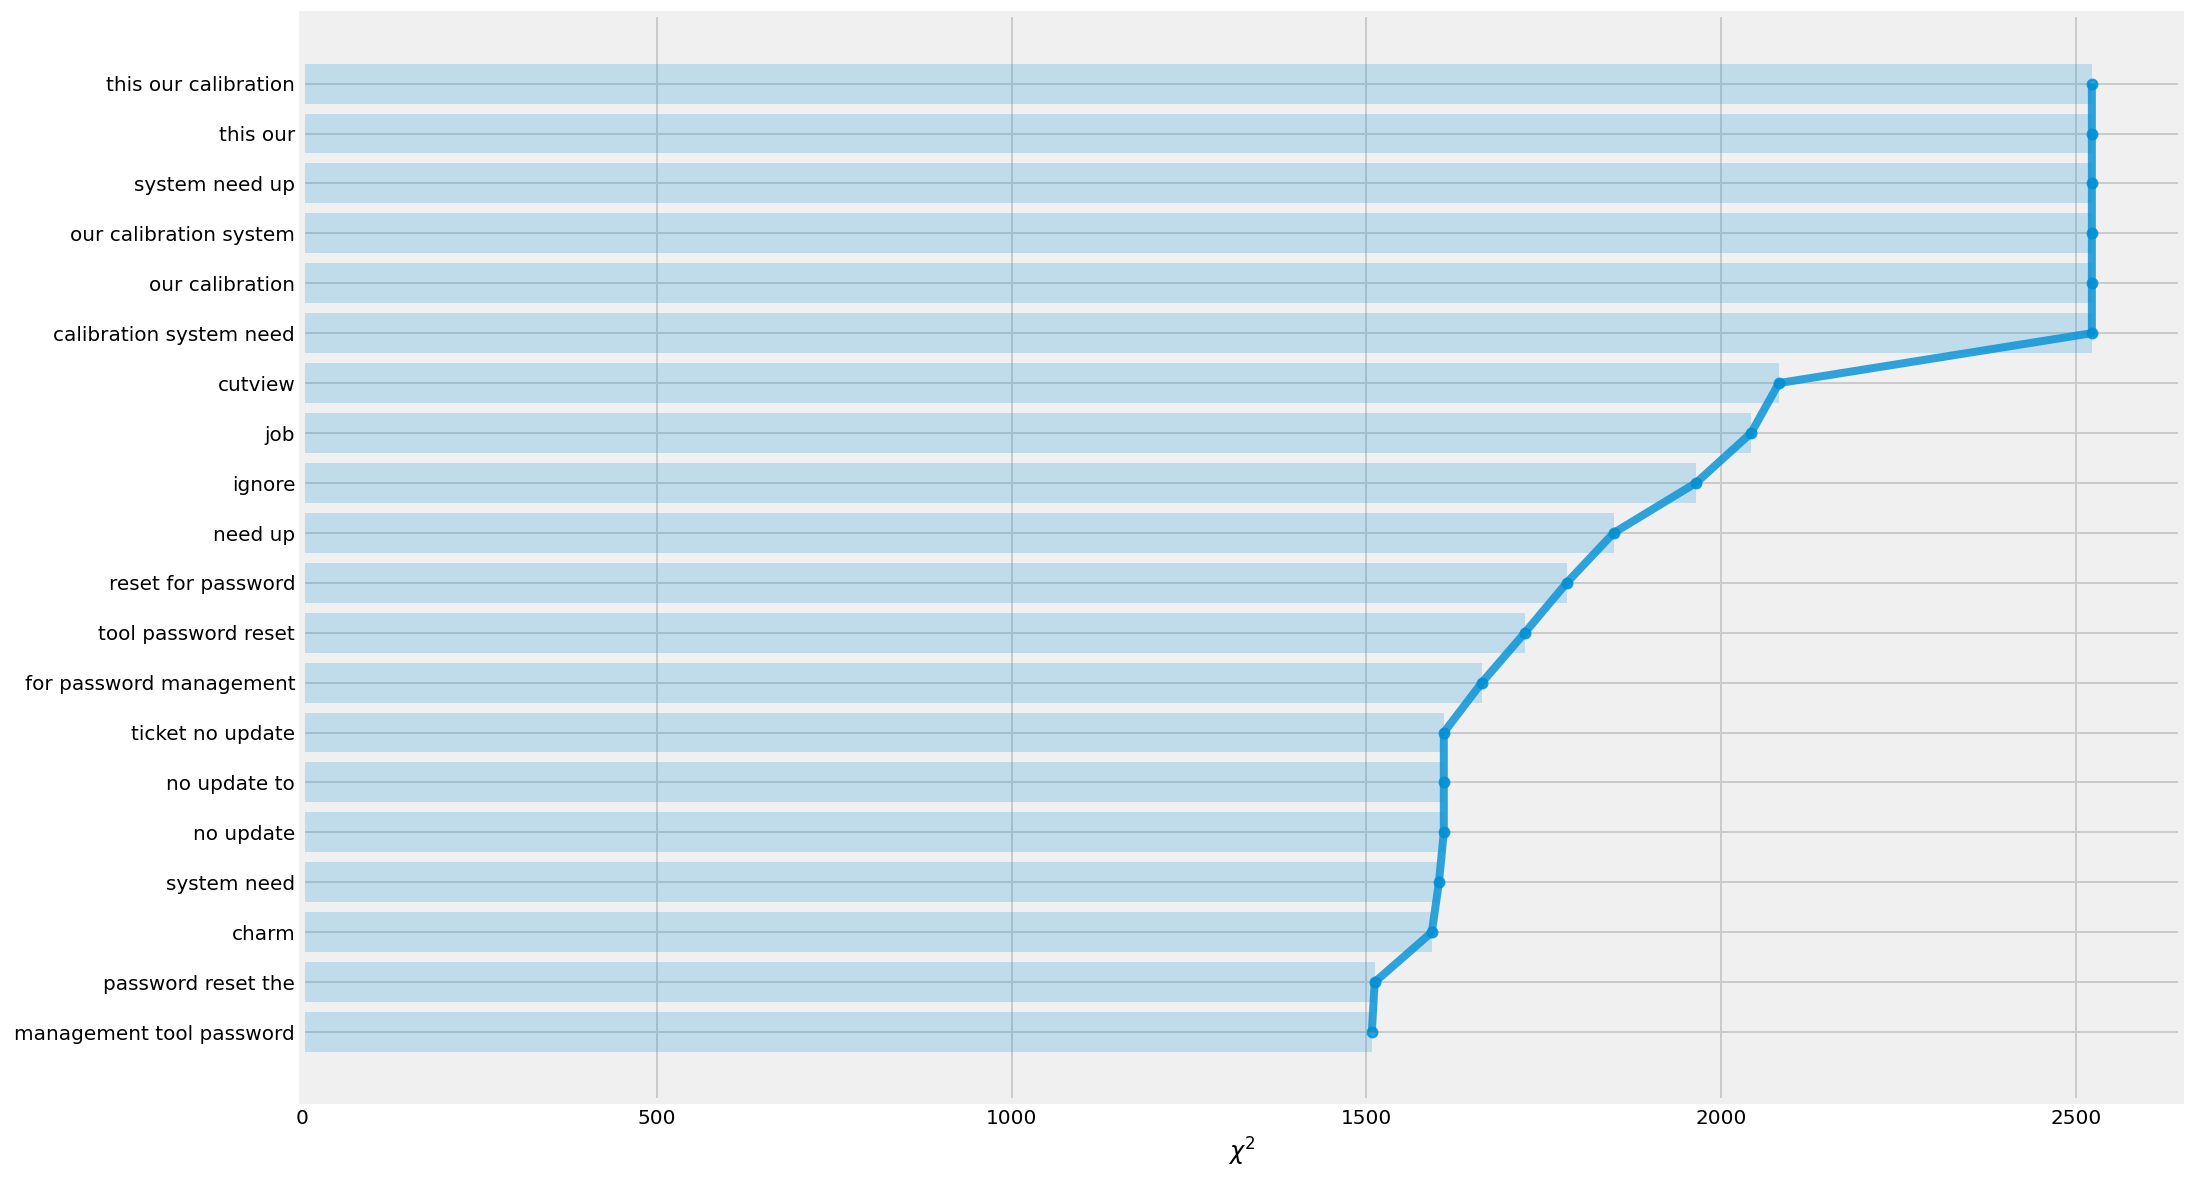

In [132]:
plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
#topchi2 = zip(wchi2)
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [133]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print ("chi2 feature selection evaluation calculated for {} features".format(n))

chi2 feature selection evaluation calculated for 10000 features
chi2 feature selection evaluation calculated for 20000 features
chi2 feature selection evaluation calculated for 30000 features
chi2 feature selection evaluation calculated for 40000 features
chi2 feature selection evaluation calculated for 50000 features
chi2 feature selection evaluation calculated for 60000 features
chi2 feature selection evaluation calculated for 70000 features
chi2 feature selection evaluation calculated for 80000 features
chi2 feature selection evaluation calculated for 90000 features


### Principal Component Analysis (PCA)

In [134]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [135]:
from sklearn.decomposition import PCA

d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

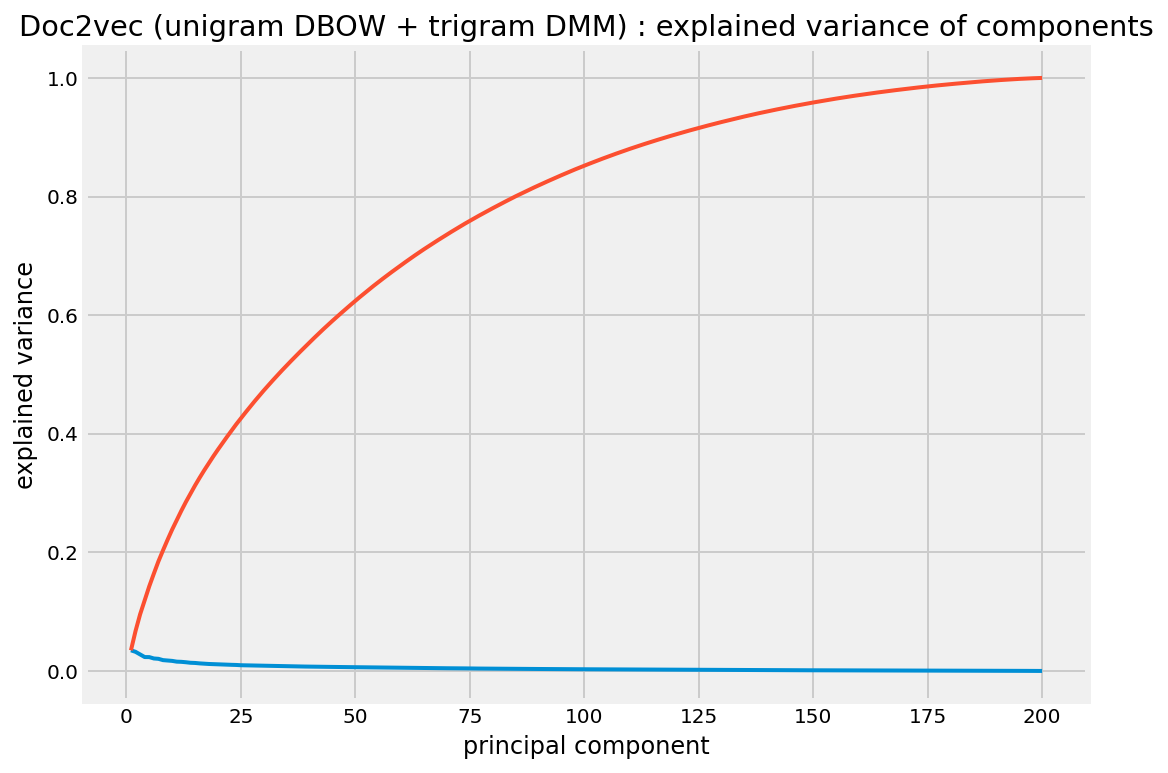

In [136]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, d2v_pca.n_components_+1)

ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [139]:
#while True:pass